In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from keras.layers import add, Conv2D, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.utils import plot_model
import tensorflow as tf


In [ ]:
print("numpy", np.__version__)
print("cv2", cv.__version__)
print("matplotlib", matplotlib.__version__)
print("keras", tf.keras.__version__)

numpy 2.0.2
cv2 4.11.0
matplotlib 3.10.0
keras 3.8.0


In [ ]:
InputPath = "/content/drive/MyDrive/LOLdataset-20241116T190231Z-001/LOLdataset/train/high"

In [ ]:
def addNoise(image):
    """Adds salt and pepper noise to an image."""
    noiseAddedImage = np.copy(image)

    # Adding salt noise
    num_salt = int(image.size * 0.01)  # 1% of image pixels
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noiseAddedImage[coords[0], coords[1], :] = 1  # White (salt)

    # Adding pepper noise
    num_pepper = int(image.size * 0.01)  # 1% of image pixels
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noiseAddedImage[coords[0], coords[1], :] = 0  # Black (pepper)

    return noiseAddedImage

In [ ]:
def PreProcessData(ImagePath):
    """Loads and preprocesses data."""
    X_ = []
    y_ = []
    print("Preprocessing data...")
    for imageName in tqdm(os.listdir(ImagePath)):
        # Load high-quality image (ground truth)
        imagePath = os.path.join(ImagePath, imageName)
        high_img = cv.imread(imagePath)
        if high_img is None:
            print(f"Warning: Skipping {imageName}, could not load.")
            continue

        # Convert BGR to RGB
        high_img = cv.cvtColor(high_img, cv.COLOR_BGR2RGB)

        # Resize to 500x500
        high_img = cv.resize(high_img, (500, 500))

        # Generate low-light image (by darkening)
        hsv = cv.cvtColor(high_img, cv.COLOR_RGB2HSV)
        hsv[..., 2] = hsv[..., 2] * 0.2  # Reduce brightness (value channel)
        low_light_img = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

        # Add noise to the low-light image
        noisy_img = addNoise(low_light_img)

        # Append to datasets
        X_.append(noisy_img)  # Input
        y_.append(high_img)   # Ground truth

    # Convert lists to NumPy arrays
    X_ = np.array(X_, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    y_ = np.array(y_, dtype=np.float32) / 255.0

    return X_, y_

In [ ]:
def InstantiateModel(input_shape):
    """Defines and builds the image enhancement model."""
    input_layer = Input(shape=input_shape)

    # Block 1
    model_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    model_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(model_1)
    model_1 = Conv2D(64, (2, 2), activation='relu', padding='same')(model_1)

    # Block 2
    model_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    model_2 = Conv2D(64, (2, 2), activation='relu', padding='same')(model_2)

    # Merge Block 1 & 2
    model_add = add([model_1, model_2])

    # Upscaling Block
    model_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(model_add)
    model_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(model_3)
    model_3 = Conv2D(16, (2, 2), activation='relu', padding='same')(model_3)

    # Output Layer
    output_layer = Conv2D(3, (3, 3), activation='relu', padding='same')(model_3)

    return Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Import necessary libraries
import os
from tqdm import tqdm  # For consistency with your style
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Your data preprocessing and model setup
# Assumes these functions are defined somewhere
# - PreProcessData
# - InstantiateModel

# Path to dataset
HighPath = "/content/drive/MyDrive/projects/LOLdataset/our485/high"

# Preprocess data
X_, y_ = PreProcessData(HighPath)
print(f"Data shapes - X_: {X_.shape}, y_: {y_.shape}")

# Instantiate the model
input_shape = (500, 500, 3)
Model_Enhancer = InstantiateModel(input_shape)

# Compile the model
Model_Enhancer.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Display model summary
Model_Enhancer.summary()

# Optionally visualize model architecture
plot_model(Model_Enhancer, to_file="model_architecture.png", show_shapes=True)

# Setup checkpoint saving
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}_loss_{loss:.4f}.h5"),
    monitor="loss",               # Change to 'val_loss' if using validation
    save_best_only=False,         # True to keep only the best model
    save_weights_only=False,      # True to only save weights
    mode="min",
    verbose=1
)

# Train the model with checkpointing
print("Training the model...")
history = Model_Enhancer.fit(
    X_, y_,
    epochs=50,
    batch_size=4,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_callback]
)

# Save final model separately
Model_Enhancer.save("image_enhancer_model.h5")
print(" Final model saved as image_enhancer_model.h5")


Preprocessing data...


 17%|█▋        | 85/486 [00:03<00:06, 58.58it/s]

100%|██████████| 486/486 [00:09<00:00, 49.38it/s]


Data shapes - X_: (485, 500, 500, 3), y_: (485, 500, 500, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 500, 500,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 500, 500,  │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 500, 500,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 500, 500,  │      8,256 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 500, 500,  │      8,256 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 500,  │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 500, 500,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 500, 500,  │     18,464 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 500, 500,  │      2,064 │ conv2d_6[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 500, 500,  │        435 │ conv2d_7[0][0]    │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,387 (314.01 KB)

 Trainable params: 80,387 (314.01 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0450
Epoch 1: saving model to checkpoints/model_epoch_01_loss_0.0169.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 247ms/step - loss: 0.0448
Epoch 2/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0023
Epoch 2: saving model to checkpoints/model_epoch_02_loss_0.0019.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 196ms/step - loss: 0.0023
Epoch 3/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0012
Epoch 3: saving model to checkpoints/model_epoch_03_loss_0.0011.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 0.0012
Epoch 4/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 7.6446e-04
Epoch 4: saving model to checkpoints/model_epoch_04_loss_0.0007.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 7.6277e-04
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 6.0519e-04
Epoch 5: saving model to checkpoints/model_epoch_05_loss_0.0005.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 6.0460e-04
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 4.9518e-04
Epoch 6: saving model to checkpoints/model_epoch_06_loss_0.0005.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - loss: 4.9500e-04
Epoch 7/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 3.8875e-04
Epoch 7: saving model to checkpoints/model_epoch_07_loss_0.0004.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 3.8862e-04
Epoch 8/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 4.0613e-04
Epoch 8: saving model to checkpoints/model_epoch_08_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 4.0519e-04
Epoch 9/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 4.1787e-04
Epoch 9: saving model to checkpoints/model_epoch_09_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - loss: 4.1673e-04
Epoch 10/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 2.8454e-04
Epoch 10: saving model to checkpoints/model_epoch_10_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - loss: 2.8436e-04
Epoch 11/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 2.7665e-04
Epoch 11: saving model to checkpoints/model_epoch_11_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 2.7753e-04
Epoch 12/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 2.9655e-04
Epoch 12: saving model to checkpoints/model_epoch_12_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 2.9622e-04
Epoch 13/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.9761e-04
Epoch 13: saving model to checkpoints/model_epoch_13_loss_0.0004.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 2.9921e-04
Epoch 14/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 4.9369e-04
Epoch 14: saving model to checkpoints/model_epoch_14_loss_0.0004.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 4.9155e-04
Epoch 15/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.1196e-04
Epoch 15: saving model to checkpoints/model_epoch_15_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 2.1182e-04
Epoch 16/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 3.2387e-04
Epoch 16: saving model to checkpoints/model_epoch_16_loss_0.0004.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 3.2551e-04
Epoch 17/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.2988e-04
Epoch 17: saving model to checkpoints/model_epoch_17_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 2.2942e-04
Epoch 18/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.7866e-04
Epoch 18: saving model to checkpoints/model_epoch_18_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 1.7866e-04
Epoch 19/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.7879e-04
Epoch 19: saving model to checkpoints/model_epoch_19_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 1.7887e-04
Epoch 20/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.7151e-04
Epoch 20: saving model to checkpoints/model_epoch_20_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 1.7190e-04
Epoch 21/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 5.0585e-04
Epoch 21: saving model to checkpoints/model_epoch_21_loss_0.0005.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - loss: 5.0546e-04
Epoch 22/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.7387e-04
Epoch 22: saving model to checkpoints/model_epoch_22_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - loss: 1.7359e-04
Epoch 23/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.5554e-04
Epoch 23: saving model to checkpoints/model_epoch_23_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 1.5604e-04
Epoch 24/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.0781e-04
Epoch 24: saving model to checkpoints/model_epoch_24_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 2.0717e-04
Epoch 25/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.4653e-04
Epoch 25: saving model to checkpoints/model_epoch_25_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 1.4652e-04
Epoch 26/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0010
Epoch 26: saving model to checkpoints/model_epoch_26_loss_0.0005.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 0.0010
Epoch 27/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.4222e-04
Epoch 27: saving model to checkpoints/model_epoch_27_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 1.4221e-04
Epoch 28/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.4150e-04
Epoch 28: saving model to checkpoints/model_epoch_28_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 1.4147e-04
Epoch 29/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.3954e-04
Epoch 29: saving model to checkpoints/model_epoch_29_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 1.3947e-04
Epoch 30/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.4065e-04
Epoch 30: saving model to checkpoints/model_epoch_30_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 1.4073e-04
Epoch 31/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.6399e-04
Epoch 31: saving model to checkpoints/model_epoch_31_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - loss: 1.6400e-04
Epoch 32/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 2.3876e-04
Epoch 32: saving model to checkpoints/model_epoch_32_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - loss: 2.3900e-04
Epoch 33/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.1336e-04
Epoch 33: saving model to checkpoints/model_epoch_33_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 1.1339e-04
Epoch 34/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1.2336e-04
Epoch 34: saving model to checkpoints/model_epoch_34_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 1.2332e-04
Epoch 35/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 2.7001e-04
Epoch 35: saving model to checkpoints/model_epoch_35_loss_0.0003.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 2.6994e-04
Epoch 36/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.3468e-04
Epoch 36: saving model to checkpoints/model_epoch_36_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 1.3477e-04
Epoch 37/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.6064e-04
Epoch 37: saving model to checkpoints/model_epoch_37_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - loss: 1.6071e-04
Epoch 38/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 5.3477e-04
Epoch 38: saving model to checkpoints/model_epoch_38_loss_0.0005.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - loss: 5.3409e-04
Epoch 39/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.1388e-04
Epoch 39: saving model to checkpoints/model_epoch_39_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - loss: 1.1385e-04
Epoch 40/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.0768e-04
Epoch 40: saving model to checkpoints/model_epoch_40_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 1.0773e-04
Epoch 41/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 9.8554e-05
Epoch 41: saving model to checkpoints/model_epoch_41_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 9.8538e-05
Epoch 42/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 9.9487e-05
Epoch 42: saving model to checkpoints/model_epoch_42_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - loss: 9.9639e-05
Epoch 43/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 2.1624e-04
Epoch 43: saving model to checkpoints/model_epoch_43_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 2.1525e-04
Epoch 44/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.4485e-04
Epoch 44: saving model to checkpoints/model_epoch_44_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - loss: 1.4461e-04
Epoch 45/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.0983e-04
Epoch 45: saving model to checkpoints/model_epoch_45_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 1.0983e-04
Epoch 46/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.4921e-04
Epoch 46: saving model to checkpoints/model_epoch_46_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - loss: 1.4903e-04
Epoch 47/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.3007e-04
Epoch 47: saving model to checkpoints/model_epoch_47_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 1.3020e-04
Epoch 48/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.5678e-04
Epoch 48: saving model to checkpoints/model_epoch_48_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 1.5672e-04
Epoch 49/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.6133e-04
Epoch 49: saving model to checkpoints/model_epoch_49_loss_0.0002.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - loss: 1.6187e-04
Epoch 50/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.3481e-04
Epoch 50: saving model to checkpoints/model_epoch_50_loss_0.0001.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - loss: 1.3439e-04


 Final model saved as image_enhancer_model.h5


In [ ]:
# Predict on a sample input
sample_idx = np.random.randint(len(X_))
low_light_sample = X_[sample_idx]
ground_truth_sample = y_[sample_idx]

enhanced_image = Model_Enhancer.predict(np.expand_dims(low_light_sample, axis=0)).squeeze()

# Rescale the enhanced image for display
enhanced_image_rescaled = np.clip(enhanced_image, 0, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


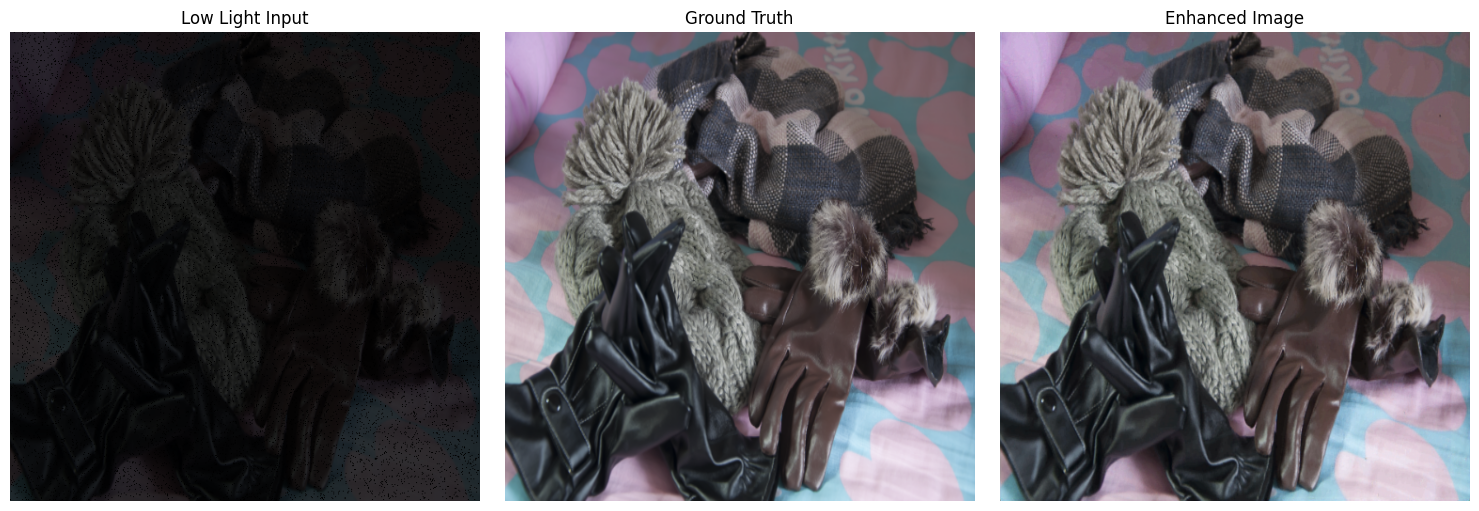

In [26]:
import matplotlib.pyplot as plt

# Assumes these three variables are defined and hold images as NumPy arrays:
# - low_light_sample
# - ground_truth_sample
# - enhanced_image_rescaled (should be in [0, 1] range for plt.imshow)

plt.figure(figsize=(15, 5))

# 1️⃣ Low Light Input
plt.subplot(1, 3, 1)
plt.imshow(low_light_sample)
plt.title("Low Light Input")
plt.axis("off")

# 2️⃣ Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_sample)
plt.title("Ground Truth")
plt.axis("off")

# 3️⃣ Enhanced Output
plt.subplot(1, 3, 3)
plt.imshow(enhanced_image_rescaled)
plt.title("Enhanced Image")
plt.axis("off")

# Show all
plt.tight_layout()
plt.show()


In [ ]:
import pickle # Import the pickle module

with open('model.pkl','wb') as file:
  pickle.dump(Model_Enhancer,file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


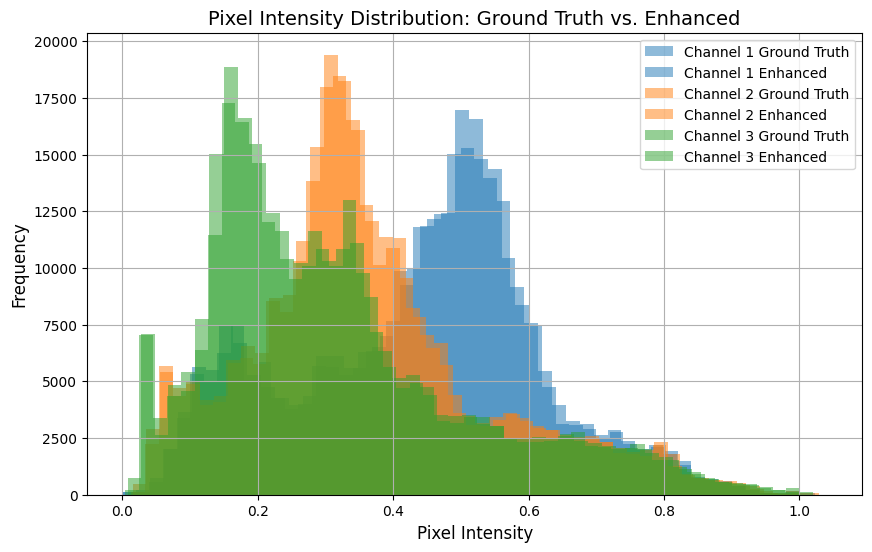

In [ ]:
# 4. Pixel Intensity Distribution
plt.figure(figsize=(10, 6))
for i in range(3):  # RGB channels
    plt.hist(y_[0][..., i].ravel(), bins=50, alpha=0.5, label=f'Channel {i+1} Ground Truth', color=f'C{i}')
    plt.hist(Model_Enhancer.predict(np.expand_dims(X_[0], axis=0)).squeeze()[..., i].ravel(), bins=50, alpha=0.5,
             label=f'Channel {i+1} Enhanced', linestyle='dashed', color=f'C{i}')
plt.title('Pixel Intensity Distribution: Ground Truth vs. Enhanced', fontsize=14)
plt.xlabel('Pixel Intensity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [ ]:
Model_Enhancer.save("image_enhancer_model.h5")


In [ ]:
from google.colab import files
files.download('image_enhancer_model.h5')

In [ ]:
from google.colab import files
files.download("app.py")

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install streamlit pyngrok

In [ ]:
from pyngrok import ngrok

# Replace 'your-token-here' with your actual authtoken
ngrok.set_auth_token("your-token-here")

In [ ]:
from pyngrok import ngrok
import subprocess
import time

# Run Streamlit app in the background
process = subprocess.Popen(["streamlit", "run", "app.py"])

# Wait for Streamlit to spin up
time.sleep(10)

# Create a tunnel to the Streamlit port
public_url = ngrok.connect(8501)
print("🔗 Streamlit app is live at:", public_url)

In [27]:
! pip install streamlit -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [28]:
!wget -q -O - ipv4.icanhazip.com

34.125.206.210


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.206.210:8501

⠴⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼your url is: https://young-swans-create.loca.lt
2025-04-22 19:55:02.024470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745351702.048770   29728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745351702.056218   29728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 19:55:07.151446: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding o